In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




```
# DOMAIN: Entertainment
• CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis.
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie
and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and
multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done. Since there higher time complexity is involved in the
• DATA DESCRIPTION: The dataset comprises of images and its mask for corresponding human face.
```



### 1. Import and Understand the data [7 Marks]

A. Import and read ‘images.npy’. [1 Marks]

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import mobilenet_v2,MobileNetV2 
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization,Activation, Conv2DTranspose, Concatenate,Reshape,ZeroPadding2D, Convolution2D,MaxPooling2D, Dense,Flatten,Softmax,Dropout
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
import pandas as pd
import glob
import os
from tensorflow.keras.metrics import Recall, Precision
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
# Standarize features
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img,img_to_array, array_to_img
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import tensorflow.keras.backend as K

In [ ]:
#Copy the images.npy file into google colab machine
!cp "/content/drive/My Drive/Colab/CV_Part2_Assignment/images.npy" .

In [ ]:
# Load the images into memory
img_arr = np.load('images.npy', allow_pickle=True)

In [ ]:
#Print the shape
print("Images shape:" , img_arr.shape)


Images shape: (409, 2)


Insights: There are total 409 images and Each images contain image array & bounary box points

B. Split the data into Features(X) & labels(Y). Unify shape of all the images. [3 Marks]

In [ ]:
# Seperate the images and its label into two different array
images = img_arr[:,0]
mask = img_arr[:,1]

In [ ]:
print(images.shape)
print(mask.shape)

(409,)
(409,)


In [ ]:
# images= [img[...,::-1] for img in images]
# images = np.array(images)

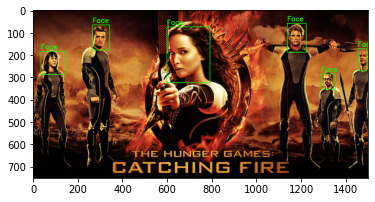

In [ ]:
#Pickup a random image number and print its boundary box on the image

img_num = np.random.randint(0, mask.shape[0])
#Read the image and draw a rectangle as per bounding box information
rand_img = images[img_num]
for label in range(len(mask[img_num])):
  obj = mask[img_num][label]
  label = obj['label']
  w = obj['imageWidth']
  h = obj['imageHeight']
  x_min = obj['points'][0]['x']*w
  y_min = obj['points'][0]['y']*h
  x_max = obj['points'][1]['x']*w
  y_max = obj['points'][1]['y']*h
  rand_img = cv2.rectangle(rand_img, 
              (int(x_min),int(y_min)),
              (int(x_max),int(y_max)), 
              (0,255,0),
              2)
   #Add Label - Class name and confidence level
  label = label[0] + "";
  rand_img = cv2.putText(rand_img, label, (int(x_min), int(y_min-10)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv2.LINE_AA)

#Convert BGR format (used by opencv to RGB format used by matplotlib)
#rand_img = cv2.cvtColor(rand_img, cv2.COLOR_BGR2RGB)

#Draw image using matplotlib
plt.imshow(rand_img)
plt.show()

In [ ]:
# set the default size is 224x224
IMG_WIDTH =224
IMG_HEIGHT=224

In [ ]:
# resize image and replace points by 1 which is in bounding box
y = np.zeros((int(images.shape[0]),IMG_HEIGHT, IMG_WIDTH))
X = np.zeros((int(images.shape[0]),IMG_HEIGHT, IMG_WIDTH, 3))
from PIL import Image
for index in range(len(images)):
  img = images[index];
  img = cv2.resize(img, (IMG_WIDTH,IMG_HEIGHT), interpolation=cv2.INTER_CUBIC)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  try:
    img = img[:, :, :3]
  except:
    continue
  X[index] = preprocess_input(np.array(img, dtype=np.float32))
  for i in range(len(mask[index])):
    obj = mask[index][i]
    w = obj['imageWidth']
    h = obj['imageHeight']
    w_scale = IMG_WIDTH
    h_scale = IMG_HEIGHT
    x_min = int(obj['points'][0]['x']*w_scale)
    y_min = int(obj['points'][0]['y']*h_scale)
    x_max = int(obj['points'][1]['x']*w_scale)
    y_max = int(obj['points'][1]['y']*h_scale)
    y[index][y_min:y_max, x_min:x_max] = 1

In [ ]:
#Prepare X and y and print its shape
print(X.shape)
print(y.shape)

(409, 224, 224, 3)
(409, 224, 224)


C. Split the data into train and test[400:9]. [1 Marks]

In [ ]:
X_train = X[0:400]
y_train =  y[0:400]

X_test = X[400:409]
y_test = y[400:409]

D. Select random image from the train data and display original image and masked image. [2 Marks]

image number  269


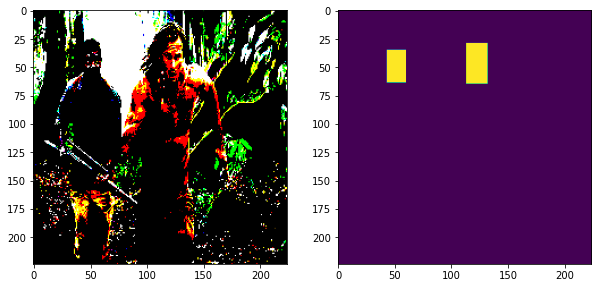

In [ ]:
img_num = np.random.randint(0, X_train.shape[0])
print('image number ', img_num)
fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(cv2.cvtColor(X_train[img_num].astype('float32'), cv2.COLOR_BGR2RGB))
ax[1].imshow(y_train[img_num])

### 2. Model building [11 Marks]

A. Design a face mask detection model.

In [ ]:
def conv_block(inputs, num_filters):
  x = Conv2D(num_filters, 3, padding="same", kernel_initializer = 'he_normal')(inputs)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)


  x = Conv2D(num_filters, 3, padding="same", kernel_initializer = 'he_normal')(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  return x

def decoder_block(inputs, skip, num_filters):
  x = Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(inputs)
  x = Concatenate()([x, skip])
  x = tf.keras.layers.Dropout(0.3)(x)
  x = conv_block(x, num_filters)
  return x;

def buildMobileNet_v2_unet(input_shape, trainable=False):
  inputs = Input(shape=input_shape)
  encoder = MobileNetV2(input_tensor=inputs,include_top=False, alpha=0.35, weights = "imagenet")
  #encoder.summary()
  for layer in encoder.layers:
      layer.trainable = trainable
  ### Skip Connection
  s1 = encoder.get_layer("input_1").output                             # (224, 224,)
  s2 = encoder.get_layer("block_1_expand_relu").output                #  (112, 112,)
  s3 = encoder.get_layer("block_3_expand_relu").output                #  (56, 56,)
  s4 = encoder.get_layer("block_6_expand_relu").output                #  (28, 28,)
  #print(s1.shape, s2.shape, s3.shape, s4.shape,s5.shape)

  """ Bridge"""
  b1 = encoder.get_layer("block_13_expand_relu").output                #  (14, 14,)

  """ Decoder """
  
  d1 = decoder_block(b1,s4, 64)               #  (28, 28,)
  print(d1.shape)
  d2 = decoder_block(d1,s3, 48)               #  (56, 56,)
  print(d2.shape)
  d3 = decoder_block(d2,s2, 32)               #  (112, 112,)
  print(d3.shape)
  d4 = decoder_block(d3,s1, 16)               #  (256, 256,)
  print(d4.shape)
  #print(d1.shape, d2.shape, d3.shape, d4.shape,  d5.shape)

  outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
  model = Model(inputs, outputs, name="mobileNetV2_U-Net")
  return model
model= buildMobileNet_v2_unet((224,224,3))
model.summary()

2031616/2019640 [==============================] - 0s 0us/step
(None, 28, 28, 64)
(None, 56, 56, 48)
(None, 112, 112, 32)
(None, 224, 224, 16)
Model: "mobileNetV2_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 16  432         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None,

In [ ]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)
model.compile(optimizer='adam', loss=dice_loss, metrics = ["acc", dice_coef, Recall(), Precision()])

In [ ]:
checkpoint = ModelCheckpoint("Q1/model.h5", monitor="val_loss", verbose=1, save_best_only=True,
                              mode="min")
stop = EarlyStopping(monitor="val_loss", patience=7, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [ ]:
BATCH = 8
train_steps = len(X_train)//BATCH
valid_steps = len(X_test)//BATCH

if len(X_train) % BATCH != 0:
    train_steps += 1
if len(X_test) % BATCH != 0:
    valid_steps += 1
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=[checkpoint,reduce_lr,stop]
)

Epoch 1/100
49/50 [============================>.] - ETA: 0s - loss: 0.7528 - acc: 0.7461 - dice_coef: 0.2472 - recall: 0.4724 - precision: 0.2385
Epoch 1: val_loss improved from inf to 0.79051, saving model to Q1/model.h5
50/50 [==============================] - 20s 76ms/step - loss: 0.7500 - acc: 0.7459 - dice_coef: 0.2500 - recall: 0.4778 - precision: 0.2416 - val_loss: 0.7905 - val_acc: 0.1993 - val_dice_coef: 0.2061 - val_recall: 0.9994 - val_precision: 0.1182 - lr: 0.0010
Epoch 2/100
49/50 [============================>.] - ETA: 0s - loss: 0.6092 - acc: 0.7831 - dice_coef: 0.3908 - recall: 0.7599 - precision: 0.3360
Epoch 2: val_loss improved from 0.79051 to 0.76349, saving model to Q1/model.h5
50/50 [==============================] - 2s 44ms/step - loss: 0.6070 - acc: 0.7837 - dice_coef: 0.3930 - recall: 0.7569 - precision: 0.3386 - val_loss: 0.7635 - val_acc: 0.3347 - val_dice_coef: 0.2327 - val_recall: 0.9992 - val_precision: 0.1389 - lr: 0.0010
Epoch 3/100
49/50 [============

D. Evaluate and share insights on performance of the model. [2 Marks]

In [ ]:
test_steps = (len(X_test)//BATCH)
if len(X_test) % BATCH != 0:
    test_steps += 1

model.evaluate(X_test, y_test, steps=test_steps)

2/2 [==============================] - 0s 15ms/step - loss: 0.4507 - acc: 0.9064 - dice_coef: 0.5549 - recall: 0.5102 - precision: 0.5718


[0.45071473717689514,
 0.9063895344734192,
 0.5548945665359497,
 0.5101990103721619,
 0.5717951059341431]



```
Insights:
1) Model is overfitting. Loss is very less in training but high in testing.
2) Dice Coef is good in training but low in testing.
3) To overcome the problem of overfitting, More images need to be added .
```



3. Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image. [2 Marks]

In [ ]:
def display_model_prediction(img_num):

    #Read Seismic image and corresponding mask
    test_img = X_test[img_num]
    feat_scaled = np.expand_dims(test_img , axis=0)
    y_pred= model.predict(feat_scaled)
    pred_mask = cv2.resize((1.0*(y_pred[0] > 0.4)), (IMG_WIDTH,IMG_WIDTH))
    
    image2 = test_img.copy()
    image2[:,:,0] = pred_mask*test_img[:,:,0]
    image2[:,:,1] = pred_mask*test_img[:,:,1]
    image2[:,:,2] = pred_mask*test_img[:,:,2]

    out_image = image2
    #print(out_image.shape)  
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (12, 8))
    
    #Show both images
    ax1.set_title('Seismic')
    
    ax1.imshow(cv2.cvtColor(test_img.astype('float32'), cv2.COLOR_BGR2RGB), cmap = 'seismic', interpolation = 'bilinear')
    #ax1.imshow(test_img, cmap = 'seismic', interpolation = 'bilinear')
    ax2.set_title('Actual Mask')
    ax2.imshow(y_test[img_num], cmap = 'gray', interpolation = 'bilinear')
    ax3.set_title('Predicted face')
    ax3.imshow(cv2.cvtColor(out_image.astype('float32'), cv2.COLOR_BGR2RGB), alpha=1)
    ax4.set_title('Predicted Mask')
    ax4.imshow(pred_mask, alpha=1)

    plt.show()


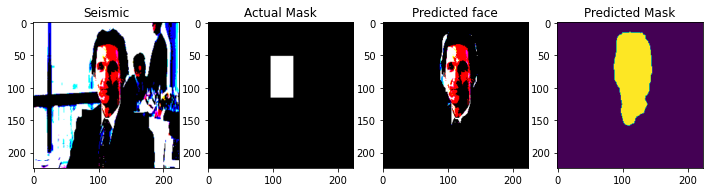

In [ ]:
display_model_prediction(3)

### PART B


```
DOMAIN: Entertainment
• CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription
basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on
the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer
vision and multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done. Since there higher time complexity is involved in the
• DATA DESCRIPTION: The dataset comprises of face images.
• PROJECT OBJECTIVE: To create an image dataset to be used by AI team build an image classifier data. Profile images of people are given.
```



In [ ]:
!cp "/content/drive/My Drive/Colab/CV_Part2_Assignment/training_images.zip" .

Steps and tasks: [ Total Score: 10 Marks]
1. Read/import images from folder ‘training_images’. [2 Marks]

In [ ]:
!unzip training_images.zip

Archive:  training_images.zip
  inflating: training_images/real_00947.jpg  
  inflating: training_images/real_01052.jpg  
  inflating: training_images/real_01042.jpg  
  inflating: training_images/real_00964.jpg  
  inflating: training_images/real_01053.jpg  
  inflating: training_images/real_00971.jpg  
  inflating: training_images/real_01057.jpg  
  inflating: training_images/real_01044.jpg  
  inflating: training_images/real_01041.jpg  
  inflating: training_images/real_01067.jpg  
  inflating: training_images/real_00969.jpg  
  inflating: training_images/real_00956.jpg  
  inflating: training_images/real_00975.jpg  
  inflating: training_images/real_01021.jpg  
  inflating: training_images/real_00945.jpg  
  inflating: training_images/real_01068.jpg  
  inflating: training_images/real_01062.jpg  
  inflating: training_images/real_01016.jpg  
  inflating: training_images/real_01065.jpg  
  inflating: training_images/real_01027.jpg  
  inflating: training_images/real_00961.jpg  
  in

In [ ]:
!ls -ls training_images

total 122204
112 -rw-r--r-- 1 root root 113848 Oct 16  2019  real_00001.jpg
100 -rw-r--r-- 1 root root  99198 Oct 16  2019  real_00002.jpg
144 -rw-r--r-- 1 root root 145564 Oct 16  2019  real_00003.jpg
136 -rw-r--r-- 1 root root 135198 Oct 16  2019  real_00004.jpg
124 -rw-r--r-- 1 root root 125060 Oct 16  2019  real_00005.jpg
112 -rw-r--r-- 1 root root 113294 Oct 16  2019  real_00006.jpg
140 -rw-r--r-- 1 root root 139881 Oct 16  2019  real_00007.jpg
132 -rw-r--r-- 1 root root 132152 Oct 16  2019  real_00008.jpg
140 -rw-r--r-- 1 root root 141830 Oct 16  2019  real_00009.jpg
104 -rw-r--r-- 1 root root 103347 Oct 16  2019  real_00010.jpg
168 -rw-r--r-- 1 root root 169147 Oct 16  2019  real_00011.jpg
124 -rw-r--r-- 1 root root 126060 Oct 16  2019  real_00012.jpg
132 -rw-r--r-- 1 root root 134739 Oct 16  2019  real_00013.jpg
112 -rw-r--r-- 1 root root 111357 Oct 16  2019  real_00014.jpg
 72 -rw-r--r-- 1 root root  73710 Oct 16  2019  real_00015.jpg
 64 -rw-r--r-- 1 root root  63801 Oct 16  

In [ ]:
# Iterate over all the images and converted into array
images = glob.glob('training_images/*.jpg')
img_list = [cv2.imread(img) for img in images]
img_list_arr = np.array(img_list)

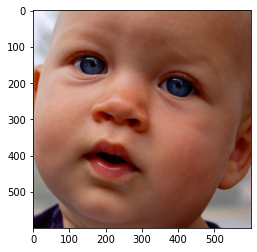

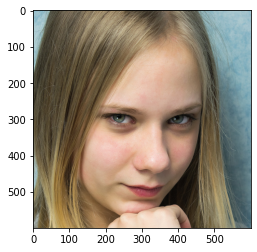

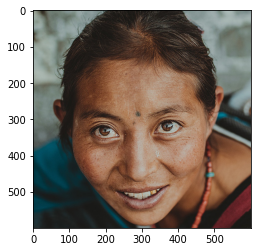

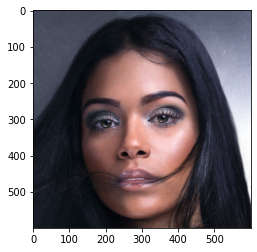

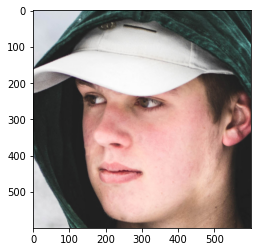

In [ ]:
#Take random image and print image
img_nums = np.random.randint(0, len(img_list)-1, 5)
for img_num in img_nums:
  plt.imshow(cv2.cvtColor(img_list[img_num], cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
# print the shape of array.
print(img_list_arr.shape)

(1091, 600, 600, 3)


Its contain 1091 images of colored 600x600

**`2. Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images. [3 Marks]`**

---



In [ ]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

--2022-09-24 07:50:21--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.06s   

2022-09-24 07:50:21 (15.4 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



X-min : 26, y-min : 33, width : 471, height: 471


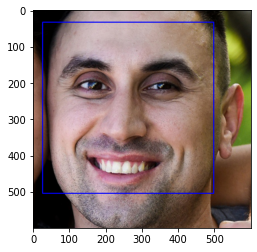

In [ ]:
# Take random image and print the bounding boxes on the image
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
test_img = img_list[np.random.randint(0, len(img_list)-1)]
grey = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(grey,1.1,4)

for (x,y,w,h) in faces:
  cv2.rectangle(test_img, (x, y), (x+w, y+h), (255, 0, 0), 2)
  print("X-min : {}, y-min : {}, width : {}, height: {}".format(x, y,w,h) )
img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(img);

In [ ]:
#Prepare a dataframe that contain cordinates of bounding boxes. It contain x cordinate, y cordinate, width, height, Total number of faces in an image and image size.
#In case, if an image contains multiple faces, multiple entries will be created for the same image with different face cordinates
face_img_df = pd.DataFrame(columns=['x','y','w','h','Total_Faces','image_Name'])
face_img_df

,x,y,w,h,Total_Faces,image_Name


Iterate over each faces and put it into the dataframe

In [ ]:
defected_images = []
undefected_images = []

for index, img in enumerate(img_list):
  face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
  grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(grey,1.1,4)
  if len(faces)==0:
    undefected_images.append(img);
    df2 = {'x': 0, 'y': 0, 'w': -1, 'h':-1, 'Total_Faces': 0, 'image_Name': images[index].split("/")[1]}
  else:
    defected_images.append(img)    
    for (x,y,w,h) in faces:
      cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
      df2 = {'x': x, 'y': y, 'w': w, 'h':h, 'Total_Faces': len(faces), 'image_Name': images[index].split("/")[1]}
  face_img_df = face_img_df.append(df2, ignore_index = True)  
print("Total Undefected Face images are : {}".format(len(undefected_images)))
print("Total defected Face images are : {}".format(len(defected_images)))

Total Undefected Face images are : 161
Total defected Face images are : 930


3. From the same loop above, extract metadata of the faces and write into a DataFrame. [3 Marks]

In [ ]:
face_img_df

,x,y,w,h,Total_Faces,image_Name
0,61,106,463,463,1,real_00548.jpg
1,61,82,462,462,1,real_00813.jpg
2,72,103,457,457,1,real_00687.jpg
3,156,366,78,78,1,real_00674.jpg
4,147,140,393,393,1,real_00785.jpg
...,...,...,...,...,...,...
1086,82,113,452,452,1,real_00293.jpg
1087,62,97,445,445,1,real_00640.jpg
1088,109,198,366,366,1,real_00297.jpg
1089,112,175,392,392,1,real_00035.jpg




```
Observation :  
1) Total records available in dataframe is 1147
2) Total Number of images are 1091
3) Some of the images are having more than 1 bounding boxes
4) Some of the images are not having single bounding boxes
5) 178 images are not having bounding boxes

```



In [ ]:
face_img_df[face_img_df.Total_Faces >1]

,x,y,w,h,Total_Faces,image_Name
23,10,459,115,115,2,real_00647.jpg
55,524,233,55,55,2,real_00911.jpg
58,21,287,56,56,2,real_00823.jpg
66,28,475,26,26,2,real_00373.jpg
71,269,387,168,168,2,real_00200.jpg
...,...,...,...,...,...,...
1035,54,261,129,129,2,real_00532.jpg
1036,29,196,160,160,2,real_00165.jpg
1065,98,165,369,369,2,real_01072.jpg
1072,428,484,110,110,2,real_00977.jpg


In [ ]:
images_morethan_1_bounding_boxes= np.unique(face_img_df[face_img_df.Total_Faces >1].image_Name)
print("Total Unqiue images which are having more than 1 bounding boxes :", len(images_morethan_1_bounding_boxes))

Total Unqiue images which are having more than 1 bounding boxes : 75


Images which are having more than 2 bounding boxes

In [ ]:
face_img_df[face_img_df.Total_Faces >2]

,x,y,w,h,Total_Faces,image_Name
292,134,173,356,356,3,real_00004.jpg
517,22,504,75,75,3,real_00980.jpg
596,501,405,52,52,3,real_00905.jpg
723,100,217,332,332,3,real_00837.jpg
756,13,562,28,28,3,real_00049.jpg
811,81,249,139,139,3,real_00730.jpg


In [ ]:
images_morethan_2_bounding_boxes= np.unique(face_img_df[face_img_df.Total_Faces >2].image_Name)
print("Total Unqiue images which are having more than 2 bounding boxes :", len(images_morethan_2_bounding_boxes))

Total Unqiue images which are having more than 2 bounding boxes : 6


4. Save the output Dataframe in .csv format. [2 Marks]

In [ ]:
face_img_df.to_csv("Images_Face.csv", index=False)
print("dataframe is saving into CSV")

dataframe is saving into CSV


### PART C




```
• DOMAIN: Face Recognition
• CONTEXT: Company X intends to build a face identification model to recognise human faces.
• DATA DESCRIPTION: The dataset comprises of images and its mask where there is a human face.
• PROJECT OBJECTIVE: Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken
from 'Pinterest' and aligned using dlib library. Some data samples:
```



1. Unzip, read and Load data(‘PINS.zip’) into session.

In [ ]:
# Copy the PINS.Zip to google colab machine
!cp "/content/drive/My Drive/Colab/CV_Part2_Assignment/PINS.zip" .

In [ ]:
# Copy the weights into google colab machine
weights_file ="vgg_face_weights.h5"
!cp "/content/drive/My Drive/Colab/CV_Part2_Assignment/vgg_face_weights.h5" .

In [ ]:
#Unzip the folder into google colab
!unzip  PINS.zip

Streaming output truncated to the last 5000 lines.
  inflating: PINS/pins_Natalie Portman /Natalie Portman 43.jpg  
  inflating: __MACOSX/PINS/pins_Natalie Portman /._Natalie Portman 43.jpg  
  inflating: PINS/pins_Natalie Portman /Natalie Portman 57.jpg  
  inflating: __MACOSX/PINS/pins_Natalie Portman /._Natalie Portman 57.jpg  
  inflating: PINS/pins_Natalie Portman /Natalie Portman 9.jpg  
  inflating: __MACOSX/PINS/pins_Natalie Portman /._Natalie Portman 9.jpg  
  inflating: PINS/pins_Natalie Portman /Natalie Portman 8.jpg  
  inflating: __MACOSX/PINS/pins_Natalie Portman /._Natalie Portman 8.jpg  
  inflating: PINS/pins_Natalie Portman /Natalie Portman 56.jpg  
  inflating: __MACOSX/PINS/pins_Natalie Portman /._Natalie Portman 56.jpg  
  inflating: PINS/pins_Natalie Portman /Natalie Portman 42.jpg  
  inflating: __MACOSX/PINS/pins_Natalie Portman /._Natalie Portman 42.jpg  
  inflating: PINS/pins_Natalie Portman /Natalie Portman 95.jpg  
  inflating: __MACOSX/PINS/pins_Natalie Po

In [ ]:
# Check the images inside the PINS folder
!ls -ls PINS

total 568
 4 drwxr-xr-x 2 root root  4096 Oct 20  2021 'pins_Aaron Paul'
12 drwxr-xr-x 2 root root 12288 Oct 20  2021 'pins_alexandra daddario'
 4 drwxr-xr-x 2 root root  4096 Oct 20  2021 'pins_Alvaro Morte'
12 drwxr-xr-x 2 root root 12288 Oct 20  2021 'pins_alycia debnam carey face'
 4 drwxr-xr-x 2 root root  4096 Oct 20  2021 'pins_Amanda Crew'
 4 drwxr-xr-x 2 root root  4096 Oct 20  2021 'pins_Amaury Nolasco'
12 drwxr-xr-x 2 root root 12288 Oct 20  2021 'pins_amber heard face'
 4 drwxr-xr-x 2 root root  4096 Oct 20  2021 'pins_Anna Gunn'
12 drwxr-xr-x 2 root root 12288 Oct 20  2021 'pins_anne hathaway'
12 drwxr-xr-x 2 root root 12288 Oct 20  2021 'pins_barbara palvin face'
 4 drwxr-xr-x 2 root root  4096 Oct 20  2021 'pins_bellamy blake face'
 4 drwxr-xr-x 2 root root  4096 Oct 20  2021 'pins_Benedict Cumberbatch'
 4 drwxr-xr-x 2 root root  4096 Oct 20  2021 'pins_Betsy Brandt'
 4 drwxr-xr-x 2 root root  4096 Oct 20  2021 'pins_bill gates'
12 drwxr-xr-x 2 root root 12288 Oct 20  20

In [ ]:
# Prepare the dataframe and create method that will add information of each image with its path into the dataframe
metaInformation_df = pd.DataFrame(columns=['Image_Name','Path','Label'])
def addMetaInformationtoDataFrame(subdir, file):
  global metaInformation_df
  df2 = {'Image_Name': file, 'Path': os.path.join(subdir, file), 'Label': subdir.split("/")[2].split('_')[1]}
  metaInformation_df = metaInformation_df.append(df2, ignore_index = True)

In [ ]:
# Load image using cv2 and convert it into RGB format
def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]

In [ ]:
#Display the image by fetching the image number from the dataframe and load image using the path present in the dataframe
def displayImage(image_num):
  img_path = metaInformation_df.loc[image_num, "Path"]
  label =  metaInformation_df.loc[image_num, "Label"]
  img = load_image(img_path)
  fig = plt.figure(figsize = (15, 7.2))
  ax = fig.add_subplot(1, 1, 1)
  ax.set_title(label, fontsize = 20)
  plt.imshow(img);

3. Write a loop to iterate through each and every image and create metadata for all the images. [4 Marks]

In [ ]:
# Specified the root directory and iterate it over each file and creating metadata information
rootdir = './PINS'
for subdir, dirs, files in os.walk(rootdir):
  for file in files:
    addMetaInformationtoDataFrame(subdir, file)

In [ ]:
#Check the total number of records in the meta data dataframe
print("Total number of records " , len(metaInformation_df))

Total number of records  10770


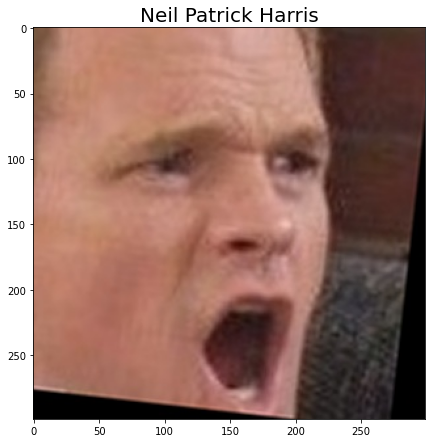

In [ ]:
# Select any random number and load the image
n = np.random.randint(0, len(metaInformation_df)-1)
displayImage(n)

In [ ]:
# count the total number of unique label present in the dataframe
print("Total number of unique labels :", len(np.unique(metaInformation_df.Label)))

Total number of unique labels : 100


4. Generate Embeddings vectors on the each face in the dataset. [4 Marks]

In [ ]:
# Define VGG_FACE_MODEL architecture
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))	
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

# Load VGG Face model weights
model.load_weights(weights_file)

In [ ]:
# Remove last Softmax layer and get model upto last flatten layer #with outputs 2622 units 
vgg_face=Model(inputs=model.layers[0].input,outputs=model.layers[-2].output) 

In [ ]:
vgg_face.inputs, vgg_face.outputs

([<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'zero_padding2d_input')>],
 [<KerasTensor: shape=(None, 2622) dtype=float32 (created by layer 'flatten')>])

In [ ]:
# Using the VGG face model, predicting each image and store it into embedding array
embeddings = np.zeros((metaInformation_df.shape[0], 2622))
for i in range(len(metaInformation_df)):
    path = metaInformation_df.loc[i, "Path"]
    img = load_image(path)
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    img_expand = np.expand_dims(img, axis=0)
    embedding_vector = vgg_face.predict(img_expand)[0]
    #print(embedding_vector.shape)
    embeddings[i]=embedding_vector

In [ ]:
print("Embedding Shape : {}", embeddings.shape)

Embedding Shape : {} (10770, 2622)


5. Build distance metrics for identifying the distance between two similar and dissimilar images. [4 Marks]

In [ ]:
# Calculate the distance between the images
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [ ]:
# Plot the images with its distance
def plot_distance_btw_pair_image(idx1, idx2):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
  plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
  ax1.imshow(load_image(metaInformation_df.loc[idx1, "Path"]))
  ax2.imshow(load_image(metaInformation_df.loc[idx2, "Path"]))

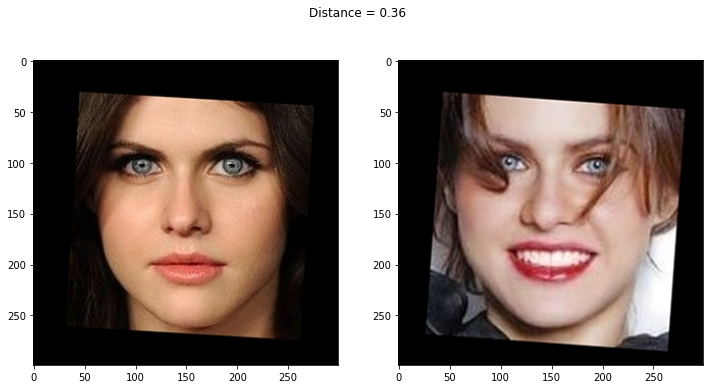

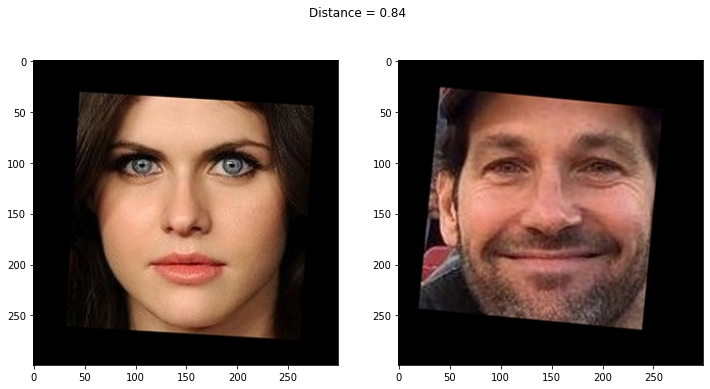

In [ ]:
# Calling similar images and different images by passing the image number
plot_distance_btw_pair_image(15,16)
plot_distance_btw_pair_image(15,357)

Split into Train/Test

In [ ]:
# Prepare the X_train, y_train, and also ensure that each label is present in both train and test
train_idx = np.arange(metaInformation_df.shape[0]) % 9 != 0
test_idx = np.arange(metaInformation_df.shape[0]) % 9 == 0
X_train = embeddings[train_idx]
X_test = embeddings[test_idx]
targets = metaInformation_df['Label']
y_train = targets[train_idx]
y_test = targets[test_idx] 

In [ ]:
print('X_train shape : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train shape : ({0},)'.format(y_train.shape[0]))
print('X_test shape : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test shape : ({0},)'.format(y_test.shape[0]))

X_train shape : (9573,2622)
y_train shape : (9573,)
X_test shape : (1197,2622)
y_test shape : (1197,)


Encode the labels 


In [ ]:
## Convert it into numbers using label encoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [ ]:
print(le.classes_)

['Aaron Paul' 'Alvaro Morte' 'Amanda Crew' 'Amaury Nolasco' 'Anna Gunn'
 'Benedict Cumberbatch' 'Betsy Brandt' 'Brenton Thwaites' 'Brit Marling'
 'Bryan Cranston' 'Caity Lotz' 'Cameron Monaghan' 'Chance Perdomo'
 'Chris Evans' 'Chris Pratt' 'Cobie Smulders' 'Danielle Panabaker'
 'Dave Franco' 'Dominic Purcell' 'Dwayne Johnson' 'Emilia Clarke'
 'Emily Bett Rickards' 'Emma Stone' 'Gwyneth Paltrow' 'Henry Cavil'
 'Jason Momoa' 'Jeremy Renner' 'Jesse Eisenberg' 'Jim Parsons'
 'Jon Bernthal' 'Josh Radnor' 'Kit Harington' 'Krysten Ritter'
 'Kumail Nanjiani' 'Maisie Williams' 'Mark Ruffalo' 'Martin Starr'
 'Melissa benoit' 'Mike Colter' 'Morena Baccarin' 'Morgan Freeman'
 'Natalie Portman ' 'Neil Patrick Harris' 'Paul Rudd' 'Pedro Alonso'
 'Peter Dinklage' 'RJ Mitte' 'Rami Melek' 'Robert Knepper' 'Robin Taylor'
 'Ryan Reynolds' 'Sarah Wayne Callies' 'Scarlett Johansson'
 'Sebastian Stan' 'Sophie Turner' 'Stephen Amell' 'Sundar Pichai'
 'Thomas Middleditch' 'Tom Cavanagh' 'Ursula Corbero' 'Wen

In [ ]:
print('y_train_encoded : ', y_train_encoded)
print('y_test_encoded : ', y_test_encoded)

y_train_encoded :  [63 63 63 ... 29 29 29]
y_test_encoded :  [63 63 63 ... 29 29 29]


In [ ]:
#Scale the dataset using standard scaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

6. Use PCA for dimensionality reduction. [2 Marks]


In [ ]:
# Using PCA, reduce the number of features
pca = PCA(n_components=128)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

7. Build an SVM classifier in order to map each image to its right person. [4 Marks]


In [ ]:
# SVC with default parameters
svc = SVC()
svc.fit(X_train_pca, y_train_encoded)

SVC()

In [ ]:
# Predict the Result
y_predict = svc.predict(X_test_pca)

In [ ]:

# Find the classification accuracy
print("Accuracy is ", accuracy_score(y_test_encoded, y_predict))

Accuracy is  0.960735171261487


8. Import and display the the test images. [2 Marks]
Hint: ‘Benedict Cumberbatch9.jpg’ and ‘Dwayne Johnson4.jpg’ are the test images.


In [ ]:
def sample_img_plot(path):
  # Load image for sample_idx from test data
  sample_img = load_image(path)
  # Normalizing pixel values
  sample_img = (sample_img/255.).astype(np.float32)
  # Resize
  sample_img = cv2.resize(sample_img, (224, 224))

  # Obtain embedding vector for sample image
  embedding = vgg_face.predict(np.expand_dims(sample_img, axis = 0))[0]
  # Scaled the vector and reshape
  embedding_scaled = scaler.transform(embedding.reshape(1, -1))
  # Predict
  sample_pred = svc.predict(pca.transform(embedding_scaled))
  # Transform back
  pred_name = le.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  return sample_img, pred_name

In [ ]:
!cp "/content/drive/My Drive/Colab/CV_Part2_Assignment/Benedict Cumberbatch9.jpg" .
!cp "/content/drive/My Drive/Colab/CV_Part2_Assignment/Dwayne Johnson4.jpg" .

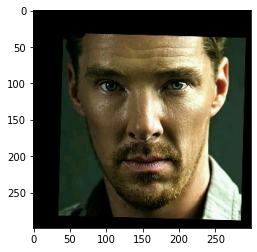

In [ ]:
plt.imshow(load_image("/content/Benedict Cumberbatch9.jpg"));

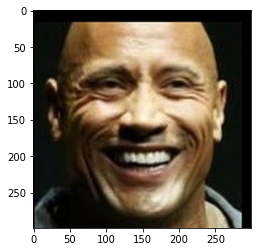

In [ ]:
plt.imshow(load_image("/content/Dwayne Johnson4.jpg"));

9. Use the trained SVM model to predict the face on both test images. [4 Marks]

Actual image is : Benedict Cumberbatch
Predicted image is : Benedict Cumberbatch


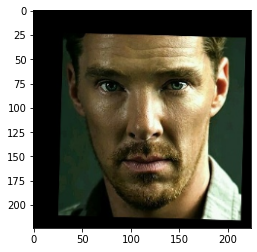

In [ ]:
img, pred_name = sample_img_plot("/content/Benedict Cumberbatch9.jpg")
plt.imshow(img)
print("Actual image is : {}".format("Benedict Cumberbatch"))
print("Predicted image is : {}".format(pred_name))

Actual image is : Dwayne Johnson
Predicted image is : Dwayne Johnson


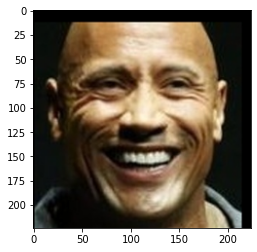

In [ ]:
img, pred_name = sample_img_plot("/content/Dwayne Johnson4.jpg")
plt.imshow(img)
print("Actual image is : {}".format("Dwayne Johnson"))
print("Predicted image is : {}".format(pred_name))
